This notebook replicates the brain-related analyses. Note: the fMRI data can be downloaded into the data folder from here: https://dataspace.princeton.edu/jspui/handle/88435/dsp01nz8062179

## Import libraries

In [1]:
import glob
import numpy as np
from os.path import join as opj
from fastdtw import fastdtw
from nilearn import datasets, plotting, surface
from nilearn.image import concat_imgs, index_img, load_img, new_img_like
from scipy.spatial.distance import correlation
from scipy.stats import pearsonr, ttest_1samp as ttest

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set paths & parameters

In [2]:
datadir = '../../../data/processed/'
figdir = '../../../paper/figs/'

sns.set_context('talk')
mpl.rcParams['pdf.fonttype'] = 42
brain_cmap = 'hot'
corrmat_cmap = plt.cm.bone_r

## Define functions

In [3]:
def r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))


def z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

## Collect permutations

In [4]:
# ref_img = load_img(datadir+'searchlight_movie/ref.nii.gz')

# for perm in range(100):
#     print('perm #%s' % str(perm))
#     imgs_recall = []
#     for sub in range(1, 18):
#         fpath = glob.glob(datadir+'searchlight_movie/s%s_perm%s_*' % (str(sub), str(perm)))
#         sub_data = np.load(fpath[0])
#         img = new_img_like(ref_img, sub_data.astype(np.float))
#         imgs_recall.append(img)
#     imgs_recall = concat_imgs(imgs_recall)
#     x, y, z, t = imgs_recall.shape
#     statmap = ttest(np.moveaxis(imgs_recall.get_data(), -1, 0), 0).statistic
#     img = new_img_like(ref_img, statmap.astype(np.float))
#     img.to_filename(datadir + 'searchlight_movie/perm%s' % str(perm))

## Load in permutations and sort them

In [5]:
perms = [load_img(datadir+'searchlight_movie/perm%s.nii' % str(perm)) for perm in range(100)]
perms = concat_imgs(perms).get_data().astype(np.float64)

## Load in real data

In [6]:
ref_img = load_img(datadir+'searchlight_movie/ref.nii.gz')
subs = range(1, 18)
imgs = []
for sub in subs:
    sub_data = np.load(datadir+'/searchlight_movie/s%s.npy' % str(sub), allow_pickle=True)
    img = new_img_like(ref_img, sub_data.astype(np.float64))
    imgs.append(img)
imgs = concat_imgs(imgs)

## Get stats for real data

In [7]:
data = imgs.get_data().astype(np.float64)
# RuntimeWarnings come from nans in masked regions
statmap = ttest(np.moveaxis(r2z(data), -1, 0), 0).statistic
img = new_img_like(ref_img, statmap.astype(np.float64))

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Do permutation correction

In [50]:
# real = img.get_data().astype(np.float64)
# x, y, z = real.shape
# pval = np.zeros_like(real)
# zval = np.zeros_like(real)
# # TO DO: update to show negative z-values and also half p-val because two-tailed test
# for i in range(x):
#     for j in range(y):
#         for k in range(z):
#             if ~np.isnan(real[i,j,k]):
#                 pval[i, j, k] = np.sum(real[i,j,k] < perms[i,j,k,:]) / 100
#                 zval[i, j, k] = (real[i,j,k] - np.nanmean(perms[i,j,k,:])) / np.nanstd(perms[i,j,k,:])

In [50]:
real = img.get_data().astype(np.float64)
pval = (real[:, :, :, np.newaxis] < perms).sum(axis=3) / 100
zval = (real - np.nanmean(perms, axis=3)) / np.nanstd(perms, axis=3)

In [51]:
pval_new = (real[:, :, :, np.newaxis] < perms).sum(axis=3) / 100
zval_new = (real - np.nanmean(perms, axis=3)) / np.nanstd(perms, axis=3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


## Threshold

In [59]:
a = np.array([1,2,3,4,5])
b = np.array([101, 102, 103, 104, 105])
c = np.array([99, 98, 97, 96, 95])
b[a < 3] = c[a < 3]

array([ 99,  98, 103, 104, 105])

In [15]:
zval[pval > .025] = 0
zval_neg = zval
zval_neg[pval < ]
# zval[zval < 0] = 0
zmap = new_img_like(ref_img, zval.astype(np.float64))

## Plot video

In [49]:
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
texture_pr = surface.vol_to_surf(zmap, fsaverage.pial_right)
texture_pl = surface.vol_to_surf(zmap, fsaverage.pial_left)

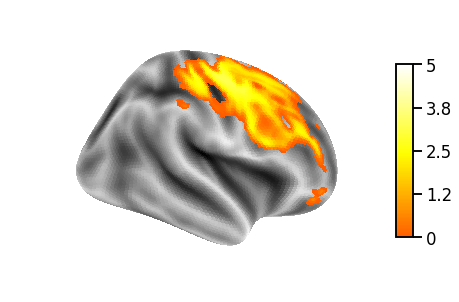

In [50]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

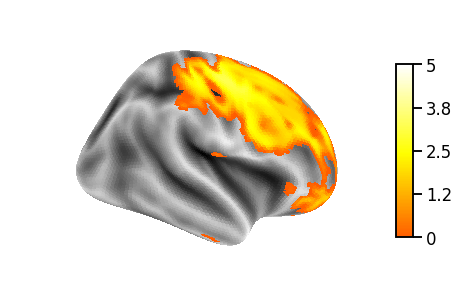

In [302]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

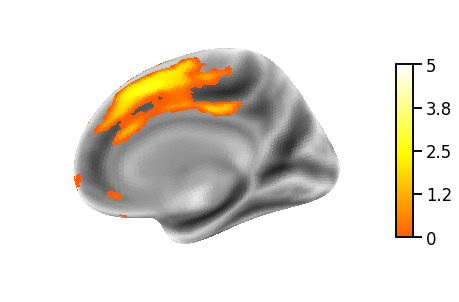

In [303]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right,
                             view='medial', cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

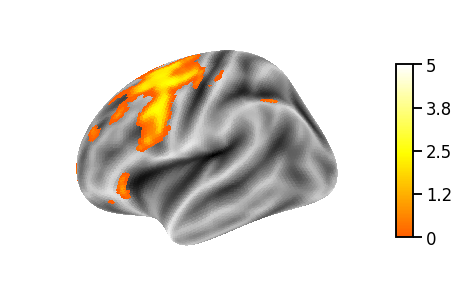

In [304]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_pl, hemi='left',
                             bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

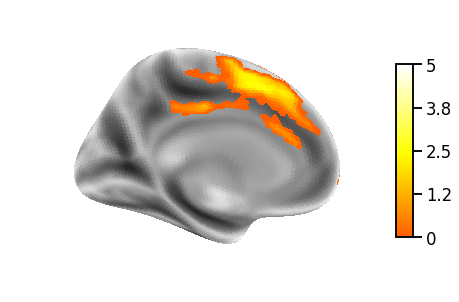

In [305]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_pl, hemi='left',
                            bg_map=fsaverage.sulc_left, view='medial', cmap=brain_cmap, threshold=.01, vmax=5)
plt.show()

## Recall analysis

In [37]:
perms = [load_img(datadir+'searchlight_recall/perm%s.nii' % str(perm)) for perm in range(1, 101)]
perms = concat_imgs(perms).get_data().astype(np.float64)
# sorted_perms = np.sort(perms.get_data(), axis=3)

In [39]:
ref_img = load_img(datadir+'searchlight_movie/ref.nii.gz')
subs = range(1, 18)
imgs = []
for sub in subs:
    sub_data = np.load(datadir + 'searchlight_recall/s%s.npy' % str(sub), allow_pickle=True)
    img = new_img_like(ref_img, sub_data.astype(np.float64))
    imgs.append(img)
imgs = concat_imgs(imgs)

In [41]:
x, y, z, t = imgs.shape
data = imgs.get_data().astype(np.float64)
# RuntimeWarnings come from nans in masked regions
statmap = ttest(np.moveaxis(data, -1, 0), 0).statistic
img = new_img_like(ref_img, statmap.astype(np.float64))

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [42]:
real = img.get_data().astype(np.float64)
x, y, z = real.shape
pval = np.zeros_like(real)*np.nan
zval = np.zeros_like(real)*np.nan
for i in range(x):
    for j in range(y):
        for k in range(z):
            if ~np.isnan(real[i,j,k]):
                pval[i, j, k] = np.sum(real[i,j,k] < perms[i,j,k,:])/100
                zval[i, j, k] = (real[i,j,k] - np.nanmean(perms[i,j,k,:])) / np.nanstd(perms[i,j,k,:])

In [43]:
zval[pval > .05] = 0
zval[zval < 0] = 0
zmap = new_img_like(ref_img, zval.astype(np.float64))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [44]:
fsaverage = datasets.fetch_surf_fsaverage5()
texture_pr = surface.vol_to_surf(zmap, fsaverage.pial_right)
texture_pl = surface.vol_to_surf(zmap, fsaverage.pial_left)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: fetch_surf_fsaverage5 has been deprecated and will be removed in a future release. Use fetch_surf_fsaverage(mesh='fsaverage5')
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/nilearn/surface/surface.py:381: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


/opt/conda/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:253: RuntimeWarning: invalid value encountered in greater_equal
  kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]


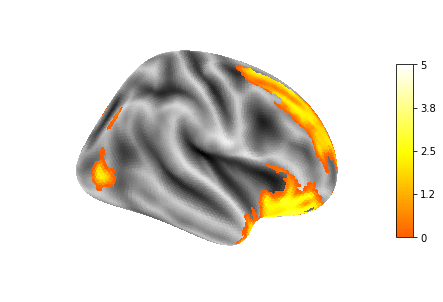

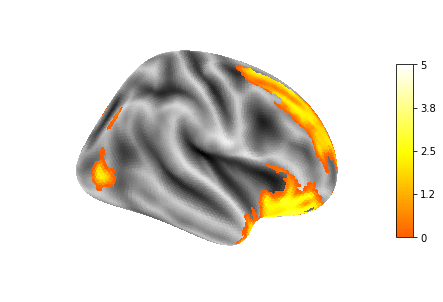

In [45]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, vmax=5)

/opt/conda/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:253: RuntimeWarning: invalid value encountered in greater_equal
  kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]


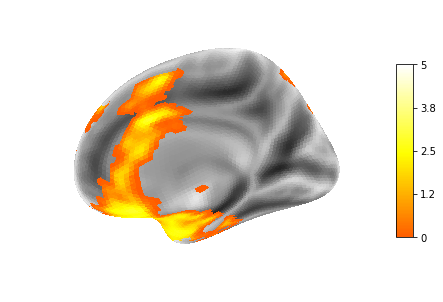

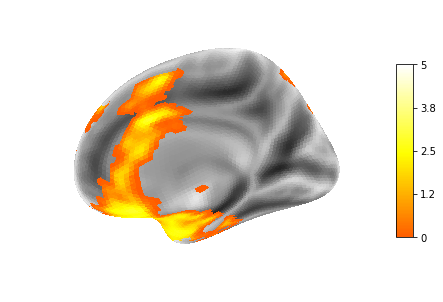

In [46]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_pr, hemi='right',
                             bg_map=fsaverage.sulc_right,
                             view='medial', cmap=brain_cmap, threshold=.01, vmax=5)

/opt/conda/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:253: RuntimeWarning: invalid value encountered in greater_equal
  kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]


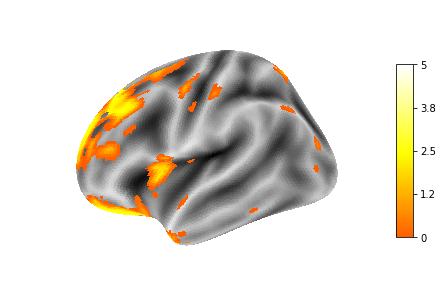

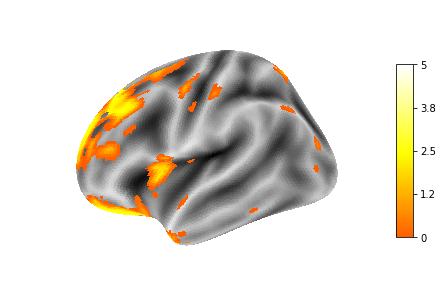

In [47]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_pl, hemi='left',
                             bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, vmax=5)

/opt/conda/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:253: RuntimeWarning: invalid value encountered in greater_equal
  kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]


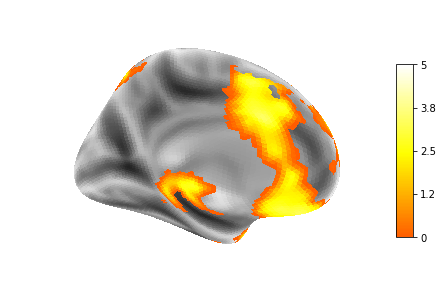

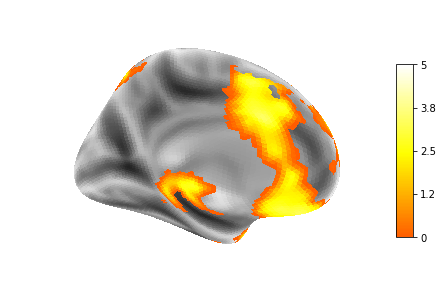

In [48]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_pl, hemi='left',
                            bg_map=fsaverage.sulc_left, view='medial', cmap=brain_cmap, threshold=.01, vmax=5)

In [268]:
video, r = np.load('../../../data/processed/models_t100_v50_r10.npy', allow_pickle=True)
recall = r[16]

In [269]:
from fastdtw import fastdtw
from scipy.spatial.distance import correlation, cdist

In [270]:
dist, path = fastdtw(video, recall, dist=correlation)

In [271]:
path

[(0, 0),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 3),
 (7, 4),
 (8, 5),
 (9, 6),
 (10, 7),
 (11, 8),
 (12, 9),
 (13, 10),
 (14, 11),
 (15, 12),
 (16, 12),
 (17, 12),
 (18, 12),
 (19, 12),
 (20, 12),
 (21, 12),
 (22, 12),
 (23, 12),
 (24, 12),
 (25, 12),
 (26, 12),
 (27, 12),
 (28, 12),
 (29, 12),
 (30, 12),
 (31, 12),
 (32, 12),
 (33, 12),
 (34, 12),
 (35, 12),
 (36, 12),
 (37, 12),
 (38, 12),
 (39, 12),
 (40, 12),
 (41, 12),
 (42, 12),
 (43, 12),
 (44, 12),
 (45, 12),
 (46, 12),
 (47, 12),
 (48, 12),
 (49, 12),
 (50, 12),
 (51, 12),
 (52, 12),
 (53, 12),
 (54, 12),
 (55, 12),
 (56, 12),
 (57, 12),
 (58, 12),
 (59, 12),
 (60, 12),
 (61, 12),
 (62, 12),
 (63, 12),
 (64, 12),
 (65, 12),
 (66, 12),
 (67, 12),
 (68, 12),
 (69, 12),
 (70, 12),
 (71, 12),
 (72, 12),
 (73, 12),
 (74, 12),
 (75, 12),
 (76, 12),
 (77, 12),
 (78, 12),
 (79, 12),
 (80, 12),
 (81, 13),
 (82, 14),
 (83, 15),
 (84, 15),
 (85, 15),
 (86, 15),
 (87, 15),
 (88, 15),
 (89, 15),
 (90, 15),
 (91, 15),
 (92, 15),


In [272]:
rec_path = [i[1] for i in path]
rec_dtw = recall[rec_path]

In [273]:
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [274]:
sns.set_context('talk')
mpl.rcParams['pdf.fonttype'] = 42
cmap = plt.cm.bone_r

In [275]:
corrmat = 1 - cdist(video, recall, 'correlation')
corrmat_dtw = 1 - cdist(video, rec_dtw, 'correlation')

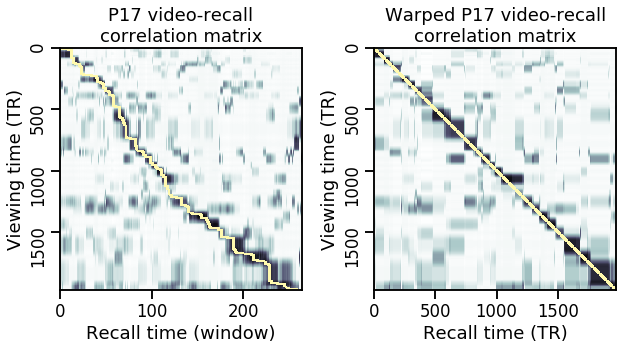

In [276]:
fig, (a, b) = plt.subplots(1, 2)
fig.set_size_inches(9, 6)
sns.heatmap(corrmat, xticklabels=100, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=a)
a.set_xlabel('Recall time (window)')
a.set_ylabel('Viewing time (TR)')
a.set_title('P17 video-recall\ncorrelation matrix')
for _, spine in a.spines.items():
    spine.set_visible(True)

a.collections[0].remove()
a.imshow(corrmat, aspect=corrmat.shape[1] / corrmat.shape[0], cmap=corrmat_cmap)
for vid_ix, rec_ix in path:
    pt = patches.Rectangle((rec_ix, vid_ix), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
    a.add_patch(pt)


sns.heatmap(corrmat_dtw, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=b)
b.set_xlabel('Recall time (TR)')
b.set_ylabel('Viewing time (TR)')
b.set_title('Warped P17 video-recall\ncorrelation matrix')
for _, spine in b.spines.items():
    spine.set_visible(True)

b.collections[0].remove()
b.imshow(corrmat_dtw, aspect='equal', cmap=corrmat_cmap)
for i in range(1976):
    pt = patches.Rectangle((i, i), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
    b.add_patch(pt)

plt.tight_layout()
# plt.savefig(opj(figdir, 'brain_corrmats.pdf', dpi=1000)
plt.show()